# Annotate with Autodistill - Base Model Grounding Dino

#### Course:Deep Neural Engineering (IM1102)
#### Group: Ellen Cordemans, Ilse Harmers & Sem Pepels

---
References
- https://docs.autodistill.com/quickstart/
- https://docs.autodistill.com/base_models/grounding-dino/
- https://github.com/autodistill/autodistill-grounding-dino
- https://github.com/roboflow/supervision/blob/develop/supervision/dataset/core.py

In [3]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import cv2
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import torch
from torchvision import io, utils
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
import pprint, shutil, sys

directory structure - after applying the base model, yolo-like subdirectories are created (train, valid and data.yaml)

```
+ Y:/ai/projects/IM1102
  + run1/grounding_dino_autodistill (YOLO project)
  + ds/grounding_dino_autodistill
      data.yaml
      data_for_roboflow.yaml
      + base (input images for training)
      + full (complete set of input images)
      + train
      + valid
      + base_output
      + yolo_output
```

In [3]:
project_root = Path("Y:/ai/projects/IM1102")
yrun_dir =     Path("Y:/ai/projects/IM1102/run1")
dataset_dir =  Path("Y:/ai/projects/IM1102/ds/grounding_dino_autodistill")

In [4]:
base_model = GroundingDINO(ontology=CaptionOntology({"0":"0", "Door":"door", "Front Yard":"front yard", "Window":"window"}))

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)


final text_encoder_type: bert-base-uncased


### apply base model

creates yolo-like directories with train, valid and data.yaml

In [6]:
results = base_model.label(input_folder=str(dataset_dir/'base'), output_folder=str(dataset_dir))

The `device` argument is deprecated and will be removed in v5 of Transformers._1440x960.jpg:   0%| | 0/20 [00:00<?, ?it
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\base\89997278_214_1440x960.jpg: 100%|█| 20/20 [28:03<00:00


Labeled dataset created - ready for distillation.


In [7]:
print(results)

### prediction

In [11]:
print(base_model.ontology.classes())

['0', 'door', 'front yard', 'window']


In [41]:
def predict_base_model(imgfn, lblfn, outimgfn):
    image = Image.open(imgfn)
    imgo  = image.copy()
    draw  = ImageDraw.Draw(imgo)
    w, h  = image.size
    class2name = {'0':'0', '1':'door', '2':'front yard', '3':'window'}
    name2class = {v: k for k, v in class2name.items()}
    results = base_model.predict(imgfn)
    result = {}
    result["boxes"]  = torch.from_numpy(results.xyxy)
    result["cls"]    = results.class_id
    result["confid"] = results.confidence
    result["labels"] = base_model.ontology.classes()
    result["colors"] = []
    result["lines"]  = []
    for box, labels in zip(result["boxes"], result["cls"]):
        if   labels == 1: color='green'
        elif labels == 3: color='red'
        elif labels == 2: color='blue'
        else:             color='black'
        result["colors"].append(color)
        [x1, y1, x2, y2] = box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)
        ixywh = [ 
            str(labels), 
            "{:.6f}".format( (x1 + ((x2-x1)/2))/w ), 
            "{:.6f}".format( (y1 + ((y2-y1)/2))/h ), 
            "{:.6f}".format( (x2-x1)/w ), 
            "{:.6f}".format( (y2-y1)/h ) 
        ]
        result["lines"].append(' '.join(ixywh))
    lblfn.write_text("\n".join(sorted(result["lines"])))
    imgo.save(outimgfn)
    #print(result)
    return imgfn, lblfn

In [43]:
flist = sorted(Path(dataset_dir/'full').glob('*.jpg'))
for imgfn in flist[2:6]:
    print(imgfn)
    shutil.copyfile(imgfn, str(dataset_dir/ ('base_output/'+imgfn.name)))
    lblfn    = dataset_dir/ ('base_output/'+imgfn.stem+'.txt')
    outimgfn = dataset_dir/ ('base_output/'+imgfn.stem+'.png')
    imgfn, lblfn = predict_base_model(imgfn, lblfn, outimgfn)

Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\full\42132455_415_1440x960.jpg
Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\full\42340258_880_1440x960.jpg
Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\full\42785832_417_1440x960.jpg
Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\full\43407668_062_1440x960.jpg


In [34]:
def predict_and_show(imafn):
    results = base_model.predict(imafn)
    print(results)
    plot(
        image=cv2.imread(imafn),
        classes=base_model.ontology.classes(),
        detections=results
    )

Detections(xyxy=array([[1263.9724   ,  533.11554  , 1372.0591   ,  771.97577  ],
       [   1.9146118,  544.37573  , 1142.6675   ,  957.4752   ],
       [ 342.1128   ,  290.8808   ,  395.60376  ,  366.65765  ],
       [ 643.2642   ,  425.6465   ,  742.93097  ,  532.9975   ],
       [ 448.10706  ,  421.86313  ,  524.47217  ,  526.9822   ],
       [ 295.19028  ,  195.05511  ,  313.56558  ,  257.3574   ],
       [ 231.96135  ,  336.17615  ,  247.85152  ,  390.8023   ],
       [ 341.66937  ,  436.9629   ,  393.8537   ,  505.7096   ],
       [ 232.62828  ,  447.102    ,  266.47385  ,  500.21515  ],
       [ 856.7351   ,  448.81805  ,  881.5509   ,  514.25104  ],
       [ 294.87424  ,  442.7914   ,  308.80685  ,  492.32034  ],
       [ 480.4274   ,  296.28662  ,  579.94794  ,  376.23834  ]],
      dtype=float32), mask=None, confidence=array([0.36617392, 0.78335273, 0.7209709 , 0.7417956 , 0.70623344,
       0.596472  , 0.52456784, 0.55800647, 0.53489983, 0.40526345,
       0.43190458, 0.3667

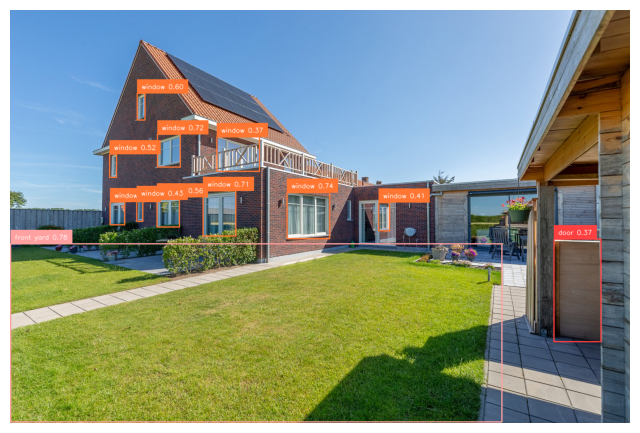

In [13]:
predict_and_show(dataset_dir/"full/42785832_417_1440x960.jpg")

## Continue with Target Model Yolov11

In [35]:
from autodistill_yolov11 import YOLOv11

In [37]:
target_model = YOLOv11("yolo11n.pt")
target_model.train(str(dataset_dir/"data.yaml"), epochs=400)


New https://pypi.org/project/ultralytics/8.3.102 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.3  Python-3.11.11 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7500U 2.70GHz)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=Y:\ai\projects\IM1102\ds\grounding_dino_autodistill\data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

train: Scanning \\nasp215\documenten\ai\projects\IM1102\ds\grounding_dino_autodistill\train\labels... 16 images, 0 back


train: New cache created: \\nasp215\documenten\ai\projects\IM1102\ds\grounding_dino_autodistill\train\labels.cache


val: Scanning \\nasp215\documenten\ai\projects\IM1102\ds\grounding_dino_autodistill\valid\labels... 4 images, 0 backgro


val: New cache created: \\nasp215\documenten\ai\projects\IM1102\ds\grounding_dino_autodistill\valid\labels.cache
Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400         0G      1.154      3.767      1.189        310        640: 100%|██████████| 1/1 [00:20<00:00, 20.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00373      0.364    0.00707    0.00171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400         0G      1.133      3.738      1.192        365        640: 100%|██████████| 1/1 [00:17<00:00, 17.47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00364      0.364     0.0061      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400         0G      1.107      3.752      1.169        432        640: 100%|██████████| 1/1 [00:14<00:00, 14.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0038      0.295    0.00435     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400         0G      1.091      3.706      1.109        303        640: 100%|██████████| 1/1 [00:11<00:00, 11.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00525      0.394       0.01    0.00328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400         0G     0.9443      3.591      1.086        302        640: 100%|██████████| 1/1 [00:10<00:00, 10.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00471      0.379    0.00827    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400         0G      1.025      3.565       1.15        316        640: 100%|██████████| 1/1 [00:10<00:00, 10.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00688      0.409     0.0167    0.00578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400         0G      0.811      3.426      1.026        300        640: 100%|██████████| 1/1 [00:10<00:00, 10.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30    0.00942      0.439     0.0176    0.00664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400         0G      0.872      3.425      1.042        355        640: 100%|██████████| 1/1 [00:10<00:00, 10.38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0139      0.485     0.0373     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400         0G     0.9341       3.37      1.029        317        640: 100%|██████████| 1/1 [00:10<00:00, 10.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0108      0.439     0.0622     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400         0G     0.8703      3.341     0.9949        354        640: 100%|██████████| 1/1 [00:10<00:00, 10.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0138       0.47      0.098      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400         0G     0.8389      3.246          1        289        640: 100%|██████████| 1/1 [00:10<00:00, 10.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0146       0.47      0.133      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400         0G     0.8983      3.228     0.9951        364        640: 100%|██████████| 1/1 [00:10<00:00, 10.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0166      0.485      0.158      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400         0G     0.8552      3.049     0.9893        243        640: 100%|██████████| 1/1 [00:10<00:00, 10.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0207      0.515      0.169       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400         0G     0.8296      2.987     0.9637        406        640: 100%|██████████| 1/1 [00:10<00:00, 10.34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0216      0.515      0.193      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400         0G     0.8792      2.898     0.9787        319        640: 100%|██████████| 1/1 [00:10<00:00, 10.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.02        0.5      0.229      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400         0G     0.8233      2.856     0.9637        434        640: 100%|██████████| 1/1 [00:11<00:00, 11.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0264      0.614      0.184      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400         0G     0.7442      2.669     0.9632        302        640: 100%|██████████| 1/1 [00:11<00:00, 11.43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0283      0.629      0.188      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400         0G     0.7697      2.559     0.9553        336        640: 100%|██████████| 1/1 [00:11<00:00, 11.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0283      0.629      0.188      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400         0G     0.8176      2.606     0.9415        346        640: 100%|██████████| 1/1 [00:09<00:00,  9.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0268      0.614       0.26      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400         0G     0.7532      2.581     0.9587        341        640: 100%|██████████| 1/1 [00:11<00:00, 11.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0268      0.614       0.26      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400         0G     0.7782      2.514     0.9457        330        640: 100%|██████████| 1/1 [00:10<00:00, 10.15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0295      0.629      0.303      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400         0G     0.8412      2.433     0.9894        328        640: 100%|██████████| 1/1 [00:12<00:00, 12.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0295      0.629      0.303      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400         0G     0.7115      2.413      0.951        312        640: 100%|██████████| 1/1 [00:10<00:00, 10.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0274      0.614      0.349       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400         0G     0.7492      2.149     0.9401        307        640: 100%|██████████| 1/1 [00:10<00:00, 10.53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0274      0.614      0.349       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400         0G     0.7239      2.144      0.943        300        640: 100%|██████████| 1/1 [00:10<00:00, 10.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0264       0.53      0.366      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400         0G     0.7393      2.086     0.9482        296        640: 100%|██████████| 1/1 [00:11<00:00, 11.74
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0264       0.53      0.366      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400         0G     0.7854      2.034      0.944        324        640: 100%|██████████| 1/1 [00:11<00:00, 11.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0253      0.515      0.363      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400         0G       0.81      2.004     0.9477        346        640: 100%|██████████| 1/1 [00:12<00:00, 12.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0253      0.515      0.363      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400         0G     0.7586      1.849     0.9294        300        640: 100%|██████████| 1/1 [00:10<00:00, 10.73
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.026      0.515      0.364      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400         0G      0.701      1.817      0.961        282        640: 100%|██████████| 1/1 [00:10<00:00, 10.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.026      0.515      0.364      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400         0G     0.6887      1.926     0.9254        338        640: 100%|██████████| 1/1 [00:13<00:00, 13.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0251        0.5      0.351      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400         0G     0.7934      1.746     0.9154        378        640: 100%|██████████| 1/1 [00:11<00:00, 11.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30     0.0251        0.5      0.351      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400         0G     0.7237      1.873     0.9258        449        640: 100%|██████████| 1/1 [00:10<00:00, 10.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0204      0.485      0.361      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400         0G     0.7245      1.621     0.8936        403        640: 100%|██████████| 1/1 [00:10<00:00, 10.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0204      0.485      0.361      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400         0G     0.7741      1.672     0.8977        409        640: 100%|██████████| 1/1 [00:10<00:00, 10.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0167       0.47      0.276      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400         0G     0.7612      1.509     0.9233        345        640: 100%|██████████| 1/1 [00:10<00:00, 10.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0167       0.47      0.276      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400         0G     0.7662      1.549     0.9355        269        640: 100%|██████████| 1/1 [00:10<00:00, 10.48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0182      0.485      0.289      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400         0G     0.8133      1.468     0.9166        369        640: 100%|██████████| 1/1 [00:11<00:00, 11.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0182      0.485      0.289      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400         0G     0.6848       1.41     0.9133        329        640: 100%|██████████| 1/1 [00:10<00:00, 10.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0234       0.53      0.223      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400         0G     0.7926      1.371     0.9049        361        640: 100%|██████████| 1/1 [00:10<00:00, 10.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0234       0.53      0.223      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400         0G     0.6587      1.299     0.9119        378        640: 100%|██████████| 1/1 [00:10<00:00, 10.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0235       0.53      0.228      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400         0G      0.725      1.347     0.9275        265        640: 100%|██████████| 1/1 [00:11<00:00, 11.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30     0.0235       0.53      0.228      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400         0G      0.717      1.262     0.9048        292        640: 100%|██████████| 1/1 [00:11<00:00, 11.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.706      0.386      0.221      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400         0G      0.697      1.331     0.9104        308        640: 100%|██████████| 1/1 [00:11<00:00, 11.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.706      0.386      0.221      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400         0G     0.7209      1.309     0.8978        389        640: 100%|██████████| 1/1 [00:11<00:00, 11.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.923     0.0455      0.242      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400         0G     0.6712       1.19     0.9174        308        640: 100%|██████████| 1/1 [00:10<00:00, 10.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.923     0.0455      0.242      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400         0G     0.7384      1.202     0.9163        327        640: 100%|██████████| 1/1 [00:10<00:00, 10.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.937     0.0455      0.213      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400         0G     0.6443      1.143     0.9202        262        640: 100%|██████████| 1/1 [00:10<00:00, 10.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.937     0.0455      0.213      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400         0G     0.6587      1.115      0.896        324        640: 100%|██████████| 1/1 [00:10<00:00, 10.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30          1     0.0564      0.224      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400         0G     0.6393       1.08     0.8945        382        640: 100%|██████████| 1/1 [00:10<00:00, 10.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30          1     0.0564      0.224      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400         0G     0.6474      1.111     0.8959        462        640: 100%|██████████| 1/1 [00:12<00:00, 12.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.697     0.0723      0.263      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400         0G     0.6698      1.101     0.9126        308        640: 100%|██████████| 1/1 [00:11<00:00, 11.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.697     0.0723      0.263      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400         0G     0.6702      1.112     0.9054        433        640: 100%|██████████| 1/1 [00:11<00:00, 11.45
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.697     0.0723      0.263      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400         0G     0.6743      1.144     0.9297        289        640: 100%|██████████| 1/1 [00:11<00:00, 11.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.733      0.117      0.246      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400         0G     0.6133      1.143     0.9059        271        640: 100%|██████████| 1/1 [00:10<00:00, 10.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.733      0.117      0.246      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400         0G     0.6847      1.096     0.8999        324        640: 100%|██████████| 1/1 [00:11<00:00, 11.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.733      0.117      0.246      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400         0G     0.6639     0.9772     0.8878        347        640: 100%|██████████| 1/1 [00:10<00:00, 10.65
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.715       0.14      0.307      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400         0G     0.6392      0.996     0.8939        389        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.715       0.14      0.307      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400         0G     0.7039      1.011     0.9192        389        640: 100%|██████████| 1/1 [00:10<00:00, 10.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.715       0.14      0.307      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400         0G     0.7078      1.001     0.8777        451        640: 100%|██████████| 1/1 [00:11<00:00, 11.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.838      0.252      0.319      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400         0G     0.6672     0.9317     0.8935        370        640: 100%|██████████| 1/1 [00:11<00:00, 11.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.838      0.252      0.319      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400         0G     0.6409     0.9586     0.8773        340        640: 100%|██████████| 1/1 [00:11<00:00, 11.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.838      0.252      0.319      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400         0G     0.6152     0.9204     0.9128        287        640: 100%|██████████| 1/1 [00:10<00:00, 10.67
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.765      0.258      0.373      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400         0G     0.6032     0.9055     0.8696        346        640: 100%|██████████| 1/1 [00:10<00:00, 10.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.765      0.258      0.373      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400         0G     0.5967     0.9142     0.9017        274        640: 100%|██████████| 1/1 [00:11<00:00, 11.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.765      0.258      0.373      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400         0G     0.6002     0.9164      0.885        271        640: 100%|██████████| 1/1 [00:11<00:00, 11.28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.822      0.285      0.396      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400         0G     0.5882     0.8847     0.9023        344        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.822      0.285      0.396      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400         0G     0.6279     0.8472     0.8671        366        640: 100%|██████████| 1/1 [00:10<00:00, 10.94
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.822      0.285      0.396      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400         0G     0.6107     0.8755     0.8733        347        640: 100%|██████████| 1/1 [00:10<00:00, 10.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.866      0.356      0.429      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400         0G     0.6069     0.8825     0.8865        308        640: 100%|██████████| 1/1 [00:10<00:00, 10.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.866      0.356      0.429      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400         0G     0.6309     0.9362     0.8799        409        640: 100%|██████████| 1/1 [00:10<00:00, 10.33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.866      0.356      0.429      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400         0G     0.6204     0.9016     0.9029        332        640: 100%|██████████| 1/1 [00:10<00:00, 10.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.868      0.449      0.551      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400         0G     0.5667     0.8165      0.884        278        640: 100%|██████████| 1/1 [00:10<00:00, 10.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.868      0.449      0.551      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400         0G     0.6031     0.8799     0.8738        450        640: 100%|██████████| 1/1 [00:10<00:00, 10.64
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.868      0.449      0.551      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400         0G     0.6586     0.8799     0.8985        271        640: 100%|██████████| 1/1 [00:10<00:00, 10.33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.854       0.47      0.555      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400         0G     0.5561     0.8342     0.8702        324        640: 100%|██████████| 1/1 [00:10<00:00, 10.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.854       0.47      0.555      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400         0G     0.6155     0.9264     0.9086        303        640: 100%|██████████| 1/1 [00:11<00:00, 11.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.854       0.47      0.555      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400         0G     0.5755     0.8666     0.8718        359        640: 100%|██████████| 1/1 [00:12<00:00, 12.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.902      0.415      0.551      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400         0G     0.6672     0.8281     0.8803        390        640: 100%|██████████| 1/1 [00:12<00:00, 12.20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.902      0.415      0.551      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400         0G     0.5558     0.8631     0.8818        243        640: 100%|██████████| 1/1 [00:22<00:00, 22.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.902      0.415      0.551      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400         0G     0.7195     0.8623     0.8947        397        640: 100%|██████████| 1/1 [00:12<00:00, 12.69
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30        0.5       0.43      0.507      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400         0G      0.616      0.806     0.8839        322        640: 100%|██████████| 1/1 [00:10<00:00, 10.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30        0.5       0.43      0.507      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400         0G     0.5716     0.7761      0.865        303        640: 100%|██████████| 1/1 [00:11<00:00, 11.34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30        0.5       0.43      0.507      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400         0G     0.5881     0.7782     0.8754        362        640: 100%|██████████| 1/1 [00:11<00:00, 11.41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.528       0.48       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400         0G     0.5701     0.8046     0.8645        390        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.528       0.48       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400         0G     0.6225     0.7685     0.8778        391        640: 100%|██████████| 1/1 [00:11<00:00, 11.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.528       0.48       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400         0G     0.5945     0.7785      0.854        367        640: 100%|██████████| 1/1 [00:11<00:00, 11.81
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.528       0.48       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400         0G     0.6236     0.8019     0.8985        289        640: 100%|██████████| 1/1 [00:11<00:00, 11.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.532      0.454      0.524      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400         0G     0.5494     0.7642     0.8558        327        640: 100%|██████████| 1/1 [00:11<00:00, 11.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.532      0.454      0.524      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400         0G     0.5575     0.7771     0.8811        262        640: 100%|██████████| 1/1 [00:10<00:00, 10.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.532      0.454      0.524      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400         0G     0.5986     0.7789     0.8813        360        640: 100%|██████████| 1/1 [00:10<00:00, 10.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.532      0.454      0.524      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400         0G     0.6482     0.8321     0.8977        325        640: 100%|██████████| 1/1 [00:11<00:00, 11.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.499      0.477      0.546      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400         0G     0.5797     0.7095     0.8906        310        640: 100%|██████████| 1/1 [00:10<00:00, 10.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.499      0.477      0.546      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400         0G     0.5342     0.7534     0.8752        291        640: 100%|██████████| 1/1 [00:10<00:00, 10.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.499      0.477      0.546      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400         0G     0.6379     0.7325     0.8826        361        640: 100%|██████████| 1/1 [00:10<00:00, 10.48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.499      0.477      0.546      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400         0G     0.6146     0.7602     0.8742        357        640: 100%|██████████| 1/1 [00:11<00:00, 11.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.932      0.472      0.557       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400         0G     0.6223     0.7393     0.8665        410        640: 100%|██████████| 1/1 [00:11<00:00, 11.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.932      0.472      0.557       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400         0G     0.6069     0.7785     0.8785        346        640: 100%|██████████| 1/1 [00:10<00:00, 10.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.932      0.472      0.557       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400         0G     0.6086     0.7707     0.8669        365        640: 100%|██████████| 1/1 [00:13<00:00, 13.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.932      0.472      0.557       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400         0G     0.6034     0.7421     0.8743        341        640: 100%|██████████| 1/1 [00:10<00:00, 10.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.527      0.477      0.563      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400         0G     0.5813     0.7068     0.8804        325        640: 100%|██████████| 1/1 [00:10<00:00, 10.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.527      0.477      0.563      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400         0G     0.5593     0.6979     0.8406        347        640: 100%|██████████| 1/1 [00:10<00:00, 10.17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.527      0.477      0.563      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400         0G     0.5893     0.7439     0.8646        336        640: 100%|██████████| 1/1 [00:10<00:00, 10.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.527      0.477      0.563      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400         0G      0.553     0.7184     0.8312        374        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.511      0.492      0.556      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400         0G     0.5307     0.6807      0.866        274        640: 100%|██████████| 1/1 [00:09<00:00,  9.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.511      0.492      0.556      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400         0G      0.603     0.7289     0.8685        381        640: 100%|██████████| 1/1 [00:10<00:00, 10.81
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.511      0.492      0.556      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400         0G     0.6246     0.6843     0.8532        400        640: 100%|██████████| 1/1 [00:10<00:00, 10.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.511      0.492      0.556      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400         0G     0.5797     0.6927     0.8691        343        640: 100%|██████████| 1/1 [00:12<00:00, 12.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.624      0.553       0.57      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400         0G      0.552     0.6905     0.8631        310        640: 100%|██████████| 1/1 [00:11<00:00, 11.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.624      0.553       0.57      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400         0G     0.5612     0.6865     0.8838        281        640: 100%|██████████| 1/1 [00:10<00:00, 10.48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.624      0.553       0.57      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400         0G     0.5386     0.6519     0.8401        331        640: 100%|██████████| 1/1 [00:10<00:00, 10.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.624      0.553       0.57      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400         0G     0.5716     0.6688     0.8686        328        640: 100%|██████████| 1/1 [00:13<00:00, 13.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.613      0.568       0.57      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400         0G     0.6032     0.7217     0.8927        276        640: 100%|██████████| 1/1 [00:12<00:00, 12.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.613      0.568       0.57      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400         0G     0.5603     0.7103     0.8696        298        640: 100%|██████████| 1/1 [00:10<00:00, 10.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.613      0.568       0.57      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400         0G     0.5528     0.6543      0.868        319        640: 100%|██████████| 1/1 [00:10<00:00, 10.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.613      0.568       0.57      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400         0G     0.5525     0.6751     0.8518        283        640: 100%|██████████| 1/1 [00:10<00:00, 10.65
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.562      0.572      0.573       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400         0G     0.5489     0.6491     0.8453        322        640: 100%|██████████| 1/1 [00:10<00:00, 10.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.562      0.572      0.573       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400         0G     0.5603     0.7214     0.8788        246        640: 100%|██████████| 1/1 [00:10<00:00, 10.14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.562      0.572      0.573       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400         0G     0.5172     0.6502     0.8746        313        640: 100%|██████████| 1/1 [00:09<00:00,  9.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.562      0.572      0.573       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400         0G      0.599     0.6798     0.8689        430        640: 100%|██████████| 1/1 [00:14<00:00, 14.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.634      0.572      0.572      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400         0G     0.4795     0.6462     0.8475        328        640: 100%|██████████| 1/1 [00:16<00:00, 16.74
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.634      0.572      0.572      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400         0G     0.4958     0.6362       0.86        297        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.634      0.572      0.572      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400         0G     0.4924     0.6504     0.8448        273        640: 100%|██████████| 1/1 [00:13<00:00, 13.24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.634      0.572      0.572      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400         0G     0.4842     0.6513     0.8549        345        640: 100%|██████████| 1/1 [00:10<00:00, 10.64
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.606       0.58      0.564      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400         0G     0.5274     0.6336     0.8542        401        640: 100%|██████████| 1/1 [00:10<00:00, 10.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.606       0.58      0.564      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400         0G     0.5576     0.7053     0.8315        462        640: 100%|██████████| 1/1 [00:10<00:00, 10.43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.606       0.58      0.564      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400         0G     0.5648     0.6392     0.8375        342        640: 100%|██████████| 1/1 [00:10<00:00, 10.26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.606       0.58      0.564      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400         0G     0.5439     0.6285     0.8661        312        640: 100%|██████████| 1/1 [00:10<00:00, 10.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.596      0.576      0.563       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400         0G     0.5489     0.6748     0.8521        287        640: 100%|██████████| 1/1 [00:10<00:00, 10.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.596      0.576      0.563       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400         0G     0.5178     0.6176     0.8386        357        640: 100%|██████████| 1/1 [00:12<00:00, 12.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.596      0.576      0.563       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400         0G     0.4907     0.6058     0.8539        369        640: 100%|██████████| 1/1 [00:11<00:00, 11.16
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.596      0.576      0.563       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400         0G     0.4878      0.624     0.8743        244        640: 100%|██████████| 1/1 [00:10<00:00, 10.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.615      0.576      0.566      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400         0G     0.4499     0.5988     0.8618        279        640: 100%|██████████| 1/1 [00:11<00:00, 11.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.615      0.576      0.566      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400         0G     0.4958     0.6203     0.8599        324        640: 100%|██████████| 1/1 [00:12<00:00, 12.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.615      0.576      0.566      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400         0G     0.4862     0.6125     0.8321        331        640: 100%|██████████| 1/1 [00:13<00:00, 13.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.615      0.576      0.566      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400         0G     0.5865      0.686     0.8551        318        640: 100%|██████████| 1/1 [00:10<00:00, 11.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.576      0.616      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400         0G     0.4809     0.6028     0.8568        357        640: 100%|██████████| 1/1 [00:11<00:00, 11.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.576      0.616      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400         0G     0.5425     0.6518     0.8407        359        640: 100%|██████████| 1/1 [00:11<00:00, 11.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.576      0.616      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400         0G     0.4959     0.6221     0.8453        377        640: 100%|██████████| 1/1 [00:11<00:00, 11.54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.576      0.616      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400         0G     0.5008     0.5876     0.8304        307        640: 100%|██████████| 1/1 [00:11<00:00, 11.47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.553      0.608      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400         0G     0.5491     0.6356     0.8548        388        640: 100%|██████████| 1/1 [00:11<00:00, 11.77
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.553      0.608      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400         0G     0.5447     0.6136     0.8294        402        640: 100%|██████████| 1/1 [00:11<00:00, 11.56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.553      0.608      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400         0G     0.5186     0.5976      0.828        417        640: 100%|██████████| 1/1 [00:11<00:00, 11.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.641      0.553      0.608      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400         0G     0.5344     0.6123     0.8566        344        640: 100%|██████████| 1/1 [00:19<00:00, 19.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.65      0.545      0.609      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400         0G     0.4872     0.5806     0.8493        365        640: 100%|██████████| 1/1 [00:13<00:00, 13.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.65      0.545      0.609      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400         0G     0.5425     0.6565     0.8633        302        640: 100%|██████████| 1/1 [00:12<00:00, 12.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.65      0.545      0.609      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400         0G     0.4968     0.5946     0.8602        335        640: 100%|██████████| 1/1 [00:11<00:00, 11.17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.65      0.545      0.609      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400         0G     0.5201     0.5822     0.8319        410        640: 100%|██████████| 1/1 [00:11<00:00, 11.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.658       0.53      0.575      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400         0G     0.5663     0.6078     0.8413        431        640: 100%|██████████| 1/1 [00:11<00:00, 11.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.658       0.53      0.575      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400         0G     0.5444     0.5931     0.8631        375        640: 100%|██████████| 1/1 [00:16<00:00, 16.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.658       0.53      0.575      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400         0G     0.5364     0.5796     0.8442        327        640: 100%|██████████| 1/1 [00:13<00:00, 13.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.658       0.53      0.575      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400         0G      0.555     0.6127     0.8325        360        640: 100%|██████████| 1/1 [00:11<00:00, 11.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.694       0.53      0.577      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400         0G     0.5459     0.6688     0.8489        322        640: 100%|██████████| 1/1 [00:11<00:00, 11.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.694       0.53      0.577      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400         0G     0.4732     0.5619     0.8314        341        640: 100%|██████████| 1/1 [00:10<00:00, 10.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.694       0.53      0.577      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400         0G     0.5161     0.5833      0.839        380        640: 100%|██████████| 1/1 [00:11<00:00, 11.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.694       0.53      0.577      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400         0G     0.4723     0.6129     0.8699        258        640: 100%|██████████| 1/1 [00:11<00:00, 11.81
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.755       0.53      0.576      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400         0G     0.5038     0.5868     0.8422        386        640: 100%|██████████| 1/1 [00:13<00:00, 13.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.755       0.53      0.576      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400         0G     0.4785     0.6192      0.852        298        640: 100%|██████████| 1/1 [00:11<00:00, 11.44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.755       0.53      0.576      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400         0G     0.5483     0.6327     0.8346        319        640: 100%|██████████| 1/1 [00:11<00:00, 11.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.755       0.53      0.576      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400         0G     0.4937     0.5739     0.8379        337        640: 100%|██████████| 1/1 [00:10<00:00, 10.76
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.77      0.529      0.568       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400         0G      0.506     0.5662     0.8282        410        640: 100%|██████████| 1/1 [00:11<00:00, 11.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.77      0.529      0.568       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400         0G     0.5106      0.564     0.8494        337        640: 100%|██████████| 1/1 [00:11<00:00, 11.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.77      0.529      0.568       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400         0G       0.45     0.6092     0.8712        231        640: 100%|██████████| 1/1 [00:10<00:00, 10.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30       0.77      0.529      0.568       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400         0G     0.4939     0.5642     0.8373        392        640: 100%|██████████| 1/1 [00:11<00:00, 11.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.735      0.526      0.548      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400         0G     0.5254     0.5988     0.8369        310        640: 100%|██████████| 1/1 [00:10<00:00, 10.73
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.735      0.526      0.548      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400         0G     0.4253     0.5584     0.8409        329        640: 100%|██████████| 1/1 [00:10<00:00, 10.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.735      0.526      0.548      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400         0G     0.4285     0.5618     0.8487        315        640: 100%|██████████| 1/1 [00:10<00:00, 10.45
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.735      0.526      0.548      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400         0G     0.5103     0.5677     0.8535        312        640: 100%|██████████| 1/1 [00:10<00:00, 10.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.638      0.561       0.52      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400         0G     0.4816     0.5723     0.8396        337        640: 100%|██████████| 1/1 [00:10<00:00, 10.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.638      0.561       0.52      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400         0G     0.4786     0.5644     0.8424        408        640: 100%|██████████| 1/1 [00:10<00:00, 10.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.638      0.561       0.52      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400         0G     0.5008     0.5577     0.8281        328        640: 100%|██████████| 1/1 [00:12<00:00, 12.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.638      0.561       0.52      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400         0G     0.4696     0.5874      0.848        277        640: 100%|██████████| 1/1 [00:11<00:00, 11.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.594      0.447      0.501      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400         0G      0.487     0.5602     0.8362        338        640: 100%|██████████| 1/1 [00:12<00:00, 12.45
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.594      0.447      0.501      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400         0G     0.5108     0.5953     0.8317        411        640: 100%|██████████| 1/1 [00:10<00:00, 10.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.594      0.447      0.501      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400         0G     0.5042     0.5543     0.8401        353        640: 100%|██████████| 1/1 [00:10<00:00, 10.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.594      0.447      0.501      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400         0G     0.4741     0.5552       0.83        356        640: 100%|██████████| 1/1 [00:12<00:00, 12.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.672       0.54      0.508      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400         0G     0.5019     0.5653     0.8363        313        640: 100%|██████████| 1/1 [00:11<00:00, 11.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.672       0.54      0.508      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400         0G     0.4701     0.5402     0.8173        353        640: 100%|██████████| 1/1 [00:11<00:00, 11.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.672       0.54      0.508      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400         0G     0.4599     0.5207     0.8147        335        640: 100%|██████████| 1/1 [00:11<00:00, 11.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.672       0.54      0.508      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400         0G     0.4573     0.5273     0.8234        366        640: 100%|██████████| 1/1 [00:11<00:00, 11.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.463      0.561      0.448       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400         0G     0.4802     0.5724     0.8496        288        640: 100%|██████████| 1/1 [00:11<00:00, 11.43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.463      0.561      0.448       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400         0G     0.4623      0.548     0.8308        290        640: 100%|██████████| 1/1 [00:12<00:00, 12.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.463      0.561      0.448       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400         0G      0.445      0.547     0.8568        329        640: 100%|██████████| 1/1 [00:11<00:00, 11.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.463      0.561      0.448       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400         0G     0.4263     0.5443     0.8317        322        640: 100%|██████████| 1/1 [00:11<00:00, 11.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.436      0.549      0.426      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400         0G     0.4362     0.5413     0.8435        334        640: 100%|██████████| 1/1 [00:13<00:00, 13.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.436      0.549      0.426      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400         0G     0.4186     0.5075     0.8314        339        640: 100%|██████████| 1/1 [00:12<00:00, 12.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.436      0.549      0.426      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400         0G     0.4654     0.5396      0.836        334        640: 100%|██████████| 1/1 [00:12<00:00, 12.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.436      0.549      0.426      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400         0G     0.4673      0.537     0.8315        377        640: 100%|██████████| 1/1 [00:11<00:00, 11.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.468      0.527      0.396      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400         0G     0.5207     0.5444     0.8268        402        640: 100%|██████████| 1/1 [00:12<00:00, 12.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.468      0.527      0.396      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400         0G     0.4276     0.5133     0.8155        373        640: 100%|██████████| 1/1 [00:11<00:00, 11.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.468      0.527      0.396      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400         0G     0.4677     0.5681       0.85        337        640: 100%|██████████| 1/1 [00:11<00:00, 11.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.468      0.527      0.396      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400         0G     0.4185     0.5182     0.8234        306        640: 100%|██████████| 1/1 [00:10<00:00, 10.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.455      0.581      0.457      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400         0G     0.4624     0.5425     0.8395        267        640: 100%|██████████| 1/1 [00:10<00:00, 10.67
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.455      0.581      0.457      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400         0G     0.5328     0.5689     0.8387        327        640: 100%|██████████| 1/1 [00:11<00:00, 11.69
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.455      0.581      0.457      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400         0G     0.4675     0.5317     0.8311        342        640: 100%|██████████| 1/1 [00:12<00:00, 12.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.455      0.581      0.457      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400         0G     0.4352     0.5019     0.8353        302        640: 100%|██████████| 1/1 [00:11<00:00, 11.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.575      0.432       0.47      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400         0G     0.4323     0.5403     0.8226        272        640: 100%|██████████| 1/1 [00:10<00:00, 10.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.575      0.432       0.47      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400         0G     0.4478     0.5405     0.8445        307        640: 100%|██████████| 1/1 [00:12<00:00, 12.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.575      0.432       0.47      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400         0G     0.4476     0.5308      0.836        375        640: 100%|██████████| 1/1 [00:11<00:00, 11.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.575      0.432       0.47      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400         0G     0.4436      0.534     0.8226        322        640: 100%|██████████| 1/1 [00:11<00:00, 11.54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.607      0.477      0.505      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400         0G     0.4426     0.5158     0.8244        398        640: 100%|██████████| 1/1 [00:10<00:00, 10.94
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.607      0.477      0.505      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400         0G     0.4173      0.522     0.8121        374        640: 100%|██████████| 1/1 [00:10<00:00, 10.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.607      0.477      0.505      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400         0G     0.4599       0.55     0.8361        282        640: 100%|██████████| 1/1 [00:10<00:00, 10.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.607      0.477      0.505      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400         0G     0.4604     0.5299     0.8251        305        640: 100%|██████████| 1/1 [00:10<00:00, 10.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.601       0.51      0.501      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400         0G     0.4439      0.543     0.8265        390        640: 100%|██████████| 1/1 [00:10<00:00, 10.45
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.601       0.51      0.501      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400         0G     0.5149     0.5295     0.8281        395        640: 100%|██████████| 1/1 [00:15<00:00, 15.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.601       0.51      0.501      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400         0G     0.4495     0.5261     0.8171        299        640: 100%|██████████| 1/1 [00:15<00:00, 15.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.601       0.51      0.501      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400         0G     0.4256     0.5187     0.8197        388        640: 100%|██████████| 1/1 [00:22<00:00, 22.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.544       0.55      0.524      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400         0G     0.4594      0.571     0.8423        285        640: 100%|██████████| 1/1 [00:22<00:00, 22.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.544       0.55      0.524      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400         0G     0.4608     0.5414     0.8209        409        640: 100%|██████████| 1/1 [00:24<00:00, 24.26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.544       0.55      0.524      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400         0G     0.4448     0.5306     0.8504        324        640: 100%|██████████| 1/1 [00:21<00:00, 21.72
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.544       0.55      0.524      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400         0G      0.408      0.503     0.8288        346        640: 100%|██████████| 1/1 [00:21<00:00, 21.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.718      0.422      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400         0G     0.4474     0.5404     0.8194        429        640: 100%|██████████| 1/1 [00:22<00:00, 22.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.718      0.422      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400         0G     0.4661     0.5126     0.8337        346        640: 100%|██████████| 1/1 [00:20<00:00, 20.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.718      0.422      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400         0G     0.4828     0.5648     0.8261        300        640: 100%|██████████| 1/1 [00:21<00:00, 21.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.718      0.422      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400         0G     0.4514     0.5292     0.8365        327        640: 100%|██████████| 1/1 [00:21<00:00, 21.53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.707      0.422      0.507      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400         0G     0.4045     0.4834     0.8403        313        640: 100%|██████████| 1/1 [00:20<00:00, 20.56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.707      0.422      0.507      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400         0G     0.4509     0.5335     0.8231        394        640: 100%|██████████| 1/1 [00:19<00:00, 19.43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.707      0.422      0.507      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400         0G     0.4142      0.503     0.8174        300        640: 100%|██████████| 1/1 [00:19<00:00, 19.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.707      0.422      0.507      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400         0G     0.3952     0.5072     0.8227        300        640: 100%|██████████| 1/1 [00:21<00:00, 21.50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30       0.75      0.428      0.565      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400         0G     0.4595     0.4936     0.8126        334        640: 100%|██████████| 1/1 [00:20<00:00, 20.28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30       0.75      0.428      0.565      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400         0G     0.4806     0.5424     0.8416        355        640: 100%|██████████| 1/1 [00:21<00:00, 21.56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30       0.75      0.428      0.565      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400         0G      0.458     0.5514     0.8253        444        640: 100%|██████████| 1/1 [00:20<00:00, 20.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30       0.75      0.428      0.565      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400         0G     0.4506     0.5115     0.8249        375        640: 100%|██████████| 1/1 [00:22<00:00, 22.94
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.819       0.44      0.568      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400         0G     0.4218     0.4838     0.8174        344        640: 100%|██████████| 1/1 [00:22<00:00, 22.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.819       0.44      0.568      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400         0G     0.4367     0.5351      0.838        279        640: 100%|██████████| 1/1 [00:20<00:00, 20.50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.819       0.44      0.568      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400         0G     0.4347     0.4927     0.8202        321        640: 100%|██████████| 1/1 [00:19<00:00, 19.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.819       0.44      0.568      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400         0G     0.4241     0.4977     0.8194        375        640: 100%|██████████| 1/1 [00:21<00:00, 21.67
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.849      0.454       0.57      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400         0G     0.4375     0.5209      0.821        417        640: 100%|██████████| 1/1 [00:19<00:00, 19.65
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.849      0.454       0.57      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400         0G     0.4885     0.5411     0.8341        328        640: 100%|██████████| 1/1 [00:20<00:00, 20.20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.849      0.454       0.57      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400         0G     0.4343     0.5161     0.8139        443        640: 100%|██████████| 1/1 [00:21<00:00, 21.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.849      0.454       0.57      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400         0G     0.3973     0.5005     0.8157        315        640: 100%|██████████| 1/1 [00:20<00:00, 20.64
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.706      0.564      0.591      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400         0G     0.4035     0.4773      0.808        348        640: 100%|██████████| 1/1 [00:19<00:00, 19.70
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.706      0.564      0.591      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400         0G     0.4501     0.5178     0.8069        433        640: 100%|██████████| 1/1 [00:23<00:00, 23.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.706      0.564      0.591      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400         0G     0.4438     0.4963      0.837        354        640: 100%|██████████| 1/1 [00:20<00:00, 20.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.706      0.564      0.591      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400         0G     0.4095     0.4892     0.8267        331        640: 100%|██████████| 1/1 [00:23<00:00, 23.17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0

                   all          4         30      0.711      0.571      0.596      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400         0G     0.4584     0.5215     0.8319        387        640: 100%|██████████| 1/1 [00:21<00:00, 21.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.711      0.571      0.596      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400         0G     0.3785     0.4702      0.809        370        640: 100%|██████████| 1/1 [00:20<00:00, 20.67
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.711      0.571      0.596      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400         0G     0.3762     0.4667     0.8183        362        640: 100%|██████████| 1/1 [00:19<00:00, 19.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all          4         30      0.711      0.571      0.596      0.446
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 139, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



239 epochs completed in 1.045 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.5MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.3  Python-3.11.11 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7500U 2.70GHz)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<0


                   all          4         30      0.641      0.576      0.616      0.517
                  door          3          4      0.466       0.25      0.275      0.192
            front yard          4          4      0.682       0.75       0.87       0.77
                window          4         22      0.774      0.727      0.703      0.589
Speed: 7.5ms preprocess, 271.4ms inference, 0.0ms loss, 19.9ms postprocess per image
Results saved to runs\detect\train3
